# Schools Analysis

In this analysis we will use scatter plots and bar charts to examine the scores of different schools.

### Read in the data

In [1]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

### Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0, sort=True)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey[survey_fields]
data["survey"] = survey

### Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

### Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

### Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

### Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

### Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

### Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

### Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


### Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

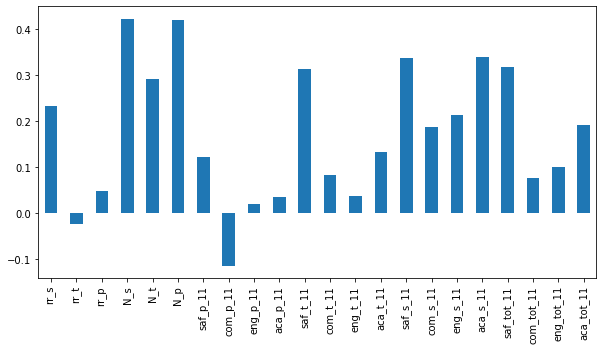

In [11]:
%matplotlib inline 
import matplotlib.pyplot as plt

correlations[survey_fields].plot(kind = 'bar', figsize = (10,5))



There are noticeable correlations between `N_s`, `N_t`, `N_p` and `sat_score`.  Since these columns are correlated with `total_enrollment`, it makes sense that they would be high.  

We also see that the student response rate `rr_s` correlates with `sat_score`. This would mean that students who do well are more likely to fill in the survey which makes sense.

`saf_t_11` and `saf_s_11` which correspond to how students an teachers perceive safety, correlate with `sat_score`.  This make sense, as it's hard to teach or learn in an unsafe environment.

The last interesting correlation is the `aca_s_11`, which indicates how the student perceives academic standards, correlates with `sat_score`, but this is not true for `aca_t_11`, how teachers perceive academic standards, or `aca_p_11`, how parents perceive academic standards.

### Exploring safety

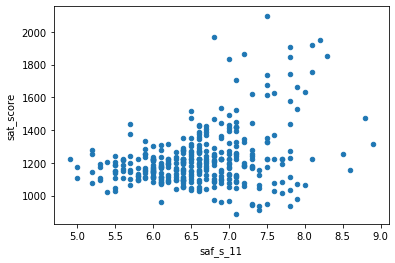

In [12]:
combined.plot(x = 'saf_s_11', y = 'sat_score' ,kind = 'scatter')

There doesn't seem to be a significant correlation between saf_s_11 and sat_score

### Plotting safety

Let's now plot the safety perceived by students saf_s_11 in a map.

In [13]:
import numpy as np
districts = combined.groupby('school_dist')
districts = districts.agg(np.mean)
districts.reset_index(inplace = True)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  if __name__ == '__main__':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  


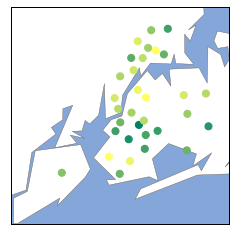

In [14]:
from mpl_toolkits.basemap import Basemap

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
m.fillcontinents(color='white',lake_color='#85A6D9')


longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()
m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True, c=districts["saf_s_11"], cmap="summer")
plt.show()

It looks like Upper Manhattan and parts of Queens and the Bronx tend to have higher safety scores, whereas Brooklyn (dark green) has low safety scores.

### Racial differences in SAT scores

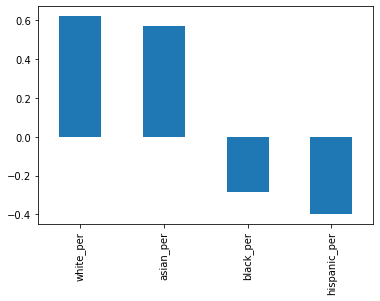

In [15]:
races = ['white_per', 'asian_per', 'black_per', 'hispanic_per']
combined.corr()['sat_score'][races].plot(kind = 'bar')

The results are actually very significative. Races of white and asian have higher scores than black and hispanic.

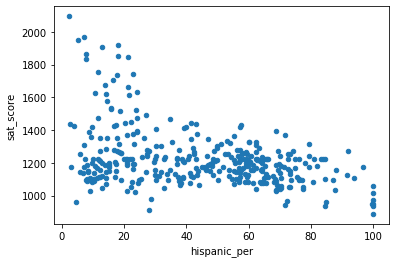

In [16]:
combined.plot(x = 'hispanic_per', y = 'sat_score', kind = 'scatter')

There are clearly two directions here. So interesting correlation. As hispanic percentage goes up, sat_score remains low.

In [17]:
combined.loc[combined['hispanic_per'] > 95, ['school_name', 'hispanic_per']]

,school_name,hispanic_per
44,Manhattan Bridges High School,99.8
82,Washington Heights Expeditionary Learning School,96.7
89,Gregorio Luperon High School for Science and M...,99.8
125,Academy for Language and Technology,99.4
141,International School for Liberal Arts,99.8
176,Pan American International High School at Monroe,99.8
253,Multicultural High School,99.8
286,Pan American International High School,100.0


The schools listed above appear to primarily be geared towards recent immigrants to the US.  These schools have a lot of students who are learning English, which would explain the lower SAT scores.

In [18]:
combined.loc[(combined['hispanic_per'] < 10) & (combined['sat_score'] > 1800), ['school_name', 'hispanic_per']]


,school_name,hispanic_per
37,Stuyvesant High School,2.4
151,Bronx High School of Science,7.2
187,Brooklyn Technical High School,7.9
327,Queens High School for the Sciences at York Co...,7.9
356,Staten Island Technical High School,5.3


Many of the schools above appear to be specialized science and technology schools that receive extra funding, and only admit students who pass an entrance exam. This doesn't explain the low hispanic_per, but it does explain why their students tend to do better on the SAT.

### Gender differences in SAT scores

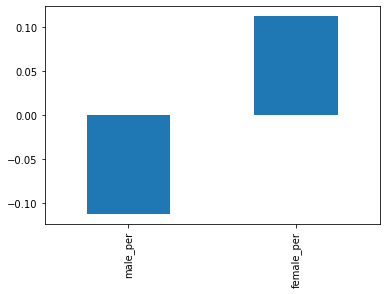

In [19]:
combined.corr()['sat_score'][['male_per', 'female_per']].plot(kind = 'bar')

Females scored better.
Let's now look at schools with high female % and high sat scores.

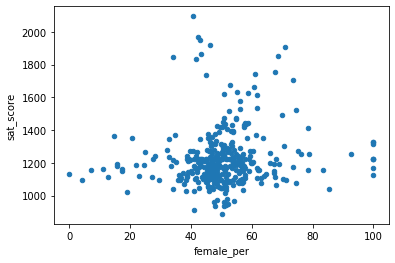

In [20]:
combined.plot(kind = 'scatter', x = 'female_per', y = 'sat_score')

Based on the scatterplot, there doesn't seem to be any real correlation between sat_score and female_per. However, there is a cluster of schools with a high percentage of females (60 to 80), and high SAT scores.

In [21]:
combined[(combined['sat_score'] > 1700) & (combined['female_per'] > 60)]['school_name']


5                         Bard High School Early College
26                         Eleanor Roosevelt High School
60                                    Beacon High School
61     Fiorello H. LaGuardia High School of Music & A...
302                          Townsend Harris High School
Name: school_name, dtype: object

These schools appears to be very selective liberal arts schools that have high academic standards.

### AP Exam Scores vs SAT Scores

In [22]:
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']

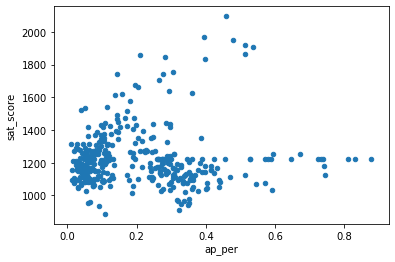

In [23]:
combined.plot(x = 'ap_per', y = 'sat_score', kind = 'scatter')

There is some correlation for ap_per > 40%. There seems to be 2 distinctive groups.